# ORENIST Classification Example

Note: This notebook is desinged to run with CPU (no GPU) runtime.

####[OCE-01]
Import modules and set random seeds.

In [1]:
import os, random
import numpy as np
import matplotlib.pyplot as plt
from pandas import DataFrame
import pickle

import tensorflow as tf
from tensorflow.keras import layers, models

random.seed(20230512)
np.random.seed(20190823)
tf.random.set_seed(20190823)

####[OCE-02]
Download the ORENIST dataset and store into NumPy arrays.

In [2]:
!curl -LO https://github.com/enakai00/colab_tfbook/raw/master/Chapter04/ORENIST.data
with open('ORENIST.data', 'rb') as file:
    images, labels = pickle.load(file)

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100  553k  100  553k    0     0  1030k      0 --:--:-- --:--:-- --:--:-- 5078k


####[OCE-03]
Define fixed convolutional filters to extract vertical and horizontal edges.

In [3]:
def edge_filter(shape=None, dtype=None):
    filter0 = np.array(
            [[ 2, 1, 0,-1,-2],
             [ 3, 2, 0,-2,-3],
             [ 4, 3, 0,-3,-4],
             [ 3, 2, 0,-2,-3],
             [ 2, 1, 0,-1,-2]]) / 23.0
    filter1 = np.array(
            [[ 2, 3, 4, 3, 2],
             [ 1, 2, 3, 2, 1],
             [ 0, 0, 0, 0, 0],
             [-1,-2,-3,-2,-1],
             [-2,-3,-4,-3,-2]]) / 23.0

    filter_array = np.zeros([5, 5, 1, 2])
    filter_array[:, :, 0, 0] = filter0
    filter_array[:, :, 0, 1] = filter1

    return filter_array

####[OCE-04]
Define a model to classify the ORENIST dataset with the fixed filters.

In [4]:
model = models.Sequential(name='edge_fileter_classification_model')
model.add(layers.Input(shape=(28*28,), name='input'))
model.add(layers.Reshape((28, 28, 1), name='reshape'))
model.add(layers.Conv2D(2, (5, 5), padding='same',
                        kernel_initializer=edge_filter,
                        use_bias=False, trainable=False,
                        name='conv_filter'))
model.add(layers.Lambda(lambda x: abs(x), name='abs'))
model.add(layers.Lambda(lambda x: tf.keras.backend.relu(x-0.2), name='cut_off'))
model.add(layers.MaxPooling2D((2, 2), name='max_pooling'))

model.add(layers.Flatten(name='flatten'))
model.add(layers.Dense(2, activation='tanh', name='hidden'))
model.add(layers.Dense(3, activation='softmax', name='softmax'))

model.summary()

Model: "edge_fileter_classification_model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ reshape (Reshape)                    │ (None, 28, 28, 1)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_filter (Conv2D)                 │ (None, 28, 28, 2)           │              50 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ abs (Lambda)                         │ (None, 28, 28, 2)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ cut_off (Lambda)                     │ (None, 28, 28, 2)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling (MaxPooling2D)           │ (None, 14, 14, 2)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 392)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ hidden (Dense)                       │ (None, 2)                   │             786 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ softmax (Dense)                      │ (None, 3)                   │               9 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 845 (3.30 KB)

 Trainable params: 795 (3.11 KB)

 Non-trainable params: 50 (200.00 B)

####[OCE-05]
Compile the model using the Adam optimizer, and Cross entroy as a loss function.

In [5]:
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['acc'])

####[OCE-06]
Train the model.

In [6]:
%%time
history = model.fit(images, labels,
                    batch_size=len(images), epochs=200, verbose=0)

CPU times: user 15.7 s, sys: 640 ms, total: 16.3 s
Wall time: 20 s


####[OCE-07]
Plot a chart to see the accuracy of the model. It achieves the 100% accuracy.

<Axes: >

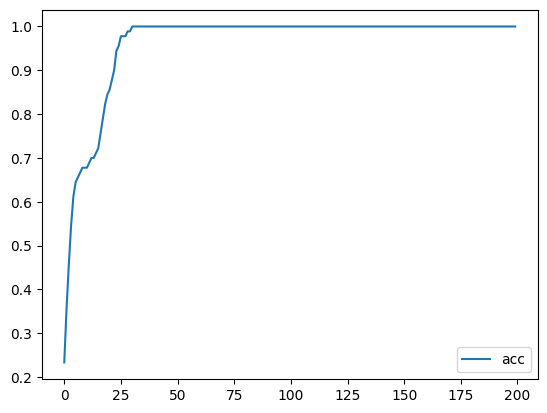

In [7]:
DataFrame({'acc': history.history['acc']}).plot()

####[OCE-08]
Define a model to extract outputs from the hidden layer.

In [8]:
layer_outputs = [model.get_layer('hidden').output]
model2 = models.Model(inputs=model.inputs[0], outputs=layer_outputs)

####[OCE-09]
Plot a chart to show the values of $(z_1, z_2)$ for each image.

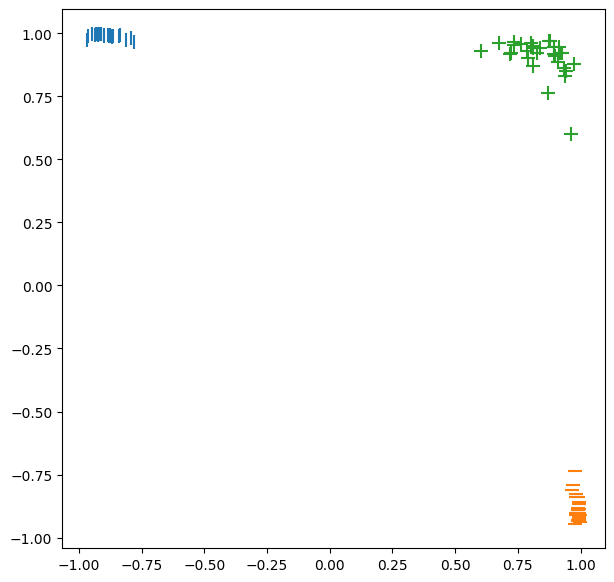

In [9]:
hidden_vals = model2.predict(images, verbose=0)

z1_vals = [[],[],[]]
z2_vals = [[],[],[]]

for hidden_val, label in zip(hidden_vals, labels):
    label_num = np.argmax(label)
    z1_vals[label_num].append(hidden_val[0])
    z2_vals[label_num].append(hidden_val[1])

fig = plt.figure(figsize=(7, 7))
subplot = fig.add_subplot(1, 1, 1)
_ = subplot.scatter(z1_vals[0], z2_vals[0], s=100, marker='|')
_ = subplot.scatter(z1_vals[1], z2_vals[1], s=100, marker='_')
_ = subplot.scatter(z1_vals[2], z2_vals[2], s=100, marker='+')